Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


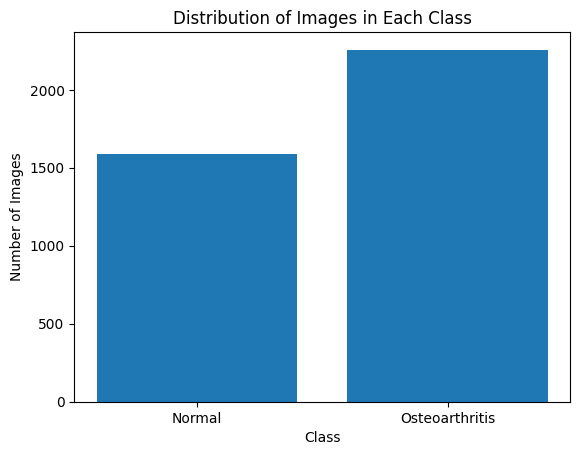

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab4/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab4/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-24 11:46:14.885272: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 11:46:14.887367: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 11:46:14.935775: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 11:46:15.152247: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 11:46:15.984343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


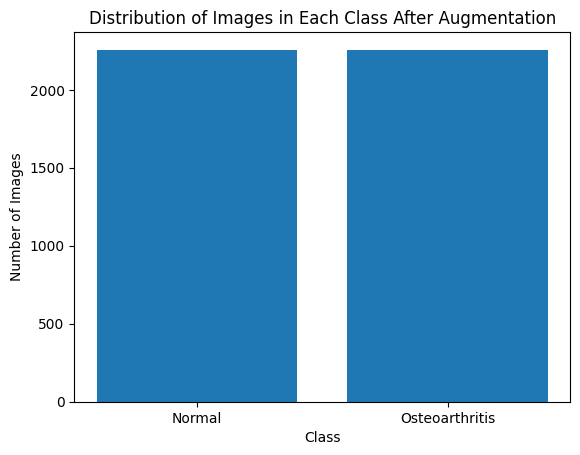

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab4/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab4/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 2257)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 2257)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 2257 + [1] * 2257  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 2527
X_test size: 1355
X_validation size: 632


In [4]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score

# ResNet

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)



# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 651ms/step - accuracy: 0.6574 - loss: 0.8981 - val_accuracy: 0.8259 - val_loss: 0.3936
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.8410 - loss: 0.3435 - val_accuracy: 0.8481 - val_loss: 0.3432
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 680ms/step - accuracy: 0.8817 - loss: 0.2873 - val_accuracy: 0.7864 - val_loss: 0.4475
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 680ms/step - accuracy: 0.8669 - loss: 0.2930 - val_accuracy: 0.8576 - val_loss: 0.3287
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 689ms/step - accuracy: 0.8909 - loss: 0.2451 - val_accuracy: 0.8655 - val_loss: 0.3279
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 695ms/step - accuracy: 0.8991 - loss: 0.2234 - val_accuracy: 0.8544 - val_loss: 0.3103
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 701ms/step - accuracy: 0.9097 - loss: 0.2157 - val_accuracy: 0.8354 - val_loss: 0.3749
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 689ms/step - accuracy: 0.9073 - loss: 0.2194 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 555ms/step
Inference Time: 24.968421936035156 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 541ms/step - accuracy: 0.8757 - loss: 0.3262
Validation Loss: 0.2978196144104004
Validation Accuracy: 0.892405092716217
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 540ms/step - accuracy: 0.8742 - loss: 0.3063
Test Loss: 0.3077678680419922
Test Accuracy: 0.876014769077301
ROC AUC Score: 0.94704535633378
Confusion Matrix:
[[643  63]
 [105 544]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       706
           1       0.90      0.84      0.87       649

    accuracy                           0.88      1355
   macro avg       0.88      0.87      0.88      1355
weighted avg       0.88      0.88      0.88      1355



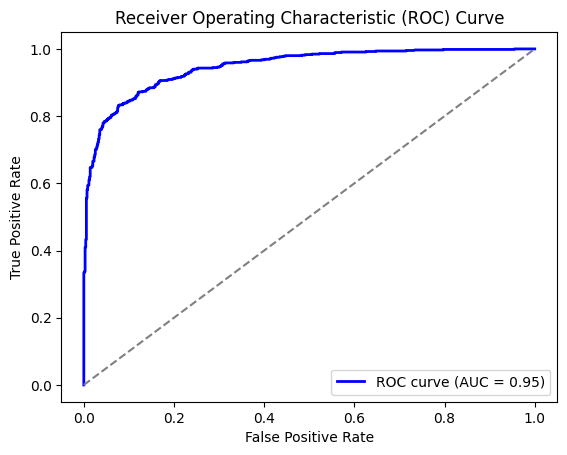

Metrics saved successfully


In [6]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import pandas as pd
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 692ms/step - accuracy: 0.9498 - loss: 0.1453 - val_accuracy: 0.8386 - val_loss: 0.3846
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 689ms/step - accuracy: 0.9473 - loss: 0.1392 - val_accuracy: 0.8813 - val_loss: 0.3102
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 691ms/step - accuracy: 0.9618 - loss: 0.1167 - val_accuracy: 0.8703 - val_loss: 0.3414
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 686ms/step - accuracy: 0.9599 - loss: 0.1180 - val_accuracy: 0.8892 - val_loss: 0.3135
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.9195 - loss: 0.1932 - val_accuracy: 0.8892 - val_loss: 0.3097
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 695ms/step - accuracy: 0.9567 - loss: 0.1125 - val_accuracy: 0.8639 - val_loss: 0.3489
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 679ms/step - accuracy: 0.9695 - loss: 0.0881 - val_accuracy: 0.8750 - val_loss: 0.3414
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 680ms/step - accuracy: 0.9599 - loss: 0.1022 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 533ms/step
Inference Time: 23.291882038116455 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 530ms/step - accuracy: 0.8672 - loss: 0.3485
Validation Loss: 0.3097282946109772
Validation Accuracy: 0.8892405033111572
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 533ms/step - accuracy: 0.8826 - loss: 0.3255
Test Loss: 0.32800740003585815
Test Accuracy: 0.8797047734260559
ROC AUC Score: 0.9505809766168914
Confusion Matrix:
[[620  86]
 [ 77 572]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       706
           1       0.87      0.88      0.88       649

    accuracy                           0.88      1355
   macro avg       0.88      0.88      0.88      1355
weighted avg       0.88      0.88      0.88      1355



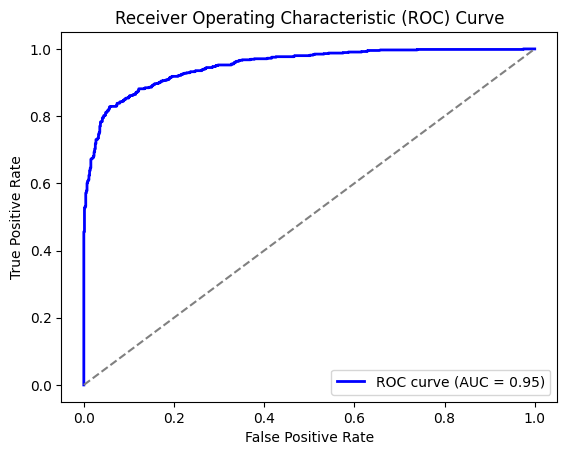

Metrics saved successfully


In [8]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [9]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 685ms/step - accuracy: 0.9694 - loss: 0.0895 - val_accuracy: 0.8924 - val_loss: 0.3293
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 680ms/step - accuracy: 0.9689 - loss: 0.0931 - val_accuracy: 0.8623 - val_loss: 0.3674
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 680ms/step - accuracy: 0.9707 - loss: 0.0830 - val_accuracy: 0.8845 - val_loss: 0.3315
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 680ms/step - accuracy: 0.9734 - loss: 0.0779 - val_accuracy: 0.8956 - val_loss: 0.3433
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 679ms/step - accuracy: 0.9752 - loss: 0.0716 - val_accuracy: 0.8734 - val_loss: 0.3990
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 681ms/step - accuracy: 0.9841 - loss: 0.0633 - val_accuracy: 0.8718 - val_loss: 0.4213
Training Time: 322.7219913005829 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 533ms/step
Inference Time: 23.308693408966064 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 531ms/step - accuracy: 0.8857 - loss: 0.3879
Validation Loss: 0.3293484151363373
Validation Accuracy: 0.892405092716217
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 531ms/step - accuracy: 0.8532 - loss: 0.4010
Test Loss: 0.41157442331314087
Test Accuracy: 0.8546125292778015
ROC AUC Score: 0.9485076190434619
Confusion Matrix:
[[560 146]
 [ 51 598]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       706
           1       0.80      0.92      0.86       649

    accuracy                           0.85      1355
   macro avg       0.86      0.86      0.85      1355
weighted avg       0.86      0.85      0.85      1355



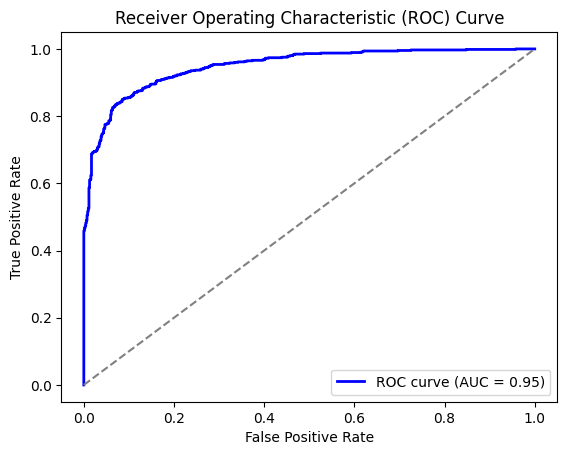

Metrics saved successfully


In [10]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 680ms/step - accuracy: 0.9727 - loss: 0.0902 - val_accuracy: 0.8750 - val_loss: 0.3470
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.9669 - loss: 0.0904 - val_accuracy: 0.8877 - val_loss: 0.3486
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.9671 - loss: 0.0887 - val_accuracy: 0.9003 - val_loss: 0.3796
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.9769 - loss: 0.0728 - val_accuracy: 0.8892 - val_loss: 0.3200
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.9705 - loss: 0.0807 - val_accuracy: 0.8655 - val_loss: 0.4697
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.9714 - loss: 0.0708 - val_accuracy: 0.8766 - val_loss: 0.3683
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.9656 - loss: 0.0864 - val_accuracy: 0.8687 - val_loss: 0.3864
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.9814 - loss: 0.0572 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 530ms/step
Inference Time: 23.205571174621582 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 531ms/step - accuracy: 0.8613 - loss: 0.3565
Validation Loss: 0.32001030445098877
Validation Accuracy: 0.8892405033111572
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 531ms/step - accuracy: 0.8880 - loss: 0.3539
Test Loss: 0.35984504222869873
Test Accuracy: 0.8833948373794556
ROC AUC Score: 0.9492256555083655
Confusion Matrix:
[[632  74]
 [ 84 565]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       706
           1       0.88      0.87      0.88       649

    accuracy                           0.88      1355
   macro avg       0.88      0.88      0.88      1355
weighted avg       0.88      0.88      0.88      1355



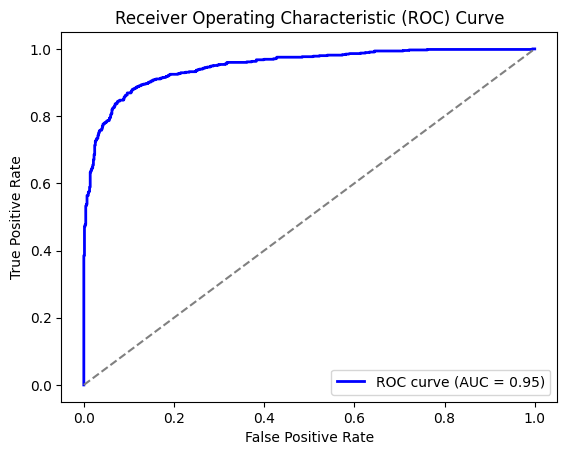

Metrics saved successfully


In [12]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

metrics={
    'Combination':'Resnet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('ResNet_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Dense+Dropout

In [9]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(128, activation='relu')(x)  # Additional dense layer
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,145,281 (92.11 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 689ms/step - accuracy: 0.6446 - loss: 0.7274 - val_accuracy: 0.8165 - val_loss: 0.4099
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 679ms/step - accuracy: 0.7728 - loss: 0.4507 - val_accuracy: 0.8149 - val_loss: 0.3918
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.8079 - loss: 0.4111 - val_accuracy: 0.8259 - val_loss: 0.3593
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 679ms/step - accuracy: 0.8168 - loss: 0.3926 - val_accuracy: 0.8418 - val_loss: 0.3536
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 685ms/step - accuracy: 0.8439 - loss: 0.3396 - val_accuracy: 0.8006 - val_loss: 0.4185
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 680ms/step - accuracy: 0.8525 - loss: 0.3311 - val_accuracy: 0.8465 - val_loss: 0.3297
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.8662 - loss: 0.2984 - val_accuracy: 0.8623 - val_loss: 0.3319
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 680ms/step - accuracy: 0.8702 - loss: 0.2895 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 542ms/step
Inference Time: 24.19751000404358 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 531ms/step - accuracy: 0.8609 - loss: 0.3322
Validation Loss: 0.3035750687122345
Validation Accuracy: 0.8829113841056824
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 530ms/step - accuracy: 0.8546 - loss: 0.3164
Test Loss: 0.32021138072013855
Test Accuracy: 0.8656826615333557
ROC AUC Score: 0.9428222543289523
Confusion Matrix:
[[603 103]
 [ 79 570]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       706
           1       0.85      0.88      0.86       649

    accuracy                           0.87      1355
   macro avg       0.87      0.87      0.87      1355
weighted avg       0.87      0.87      0.87      1355



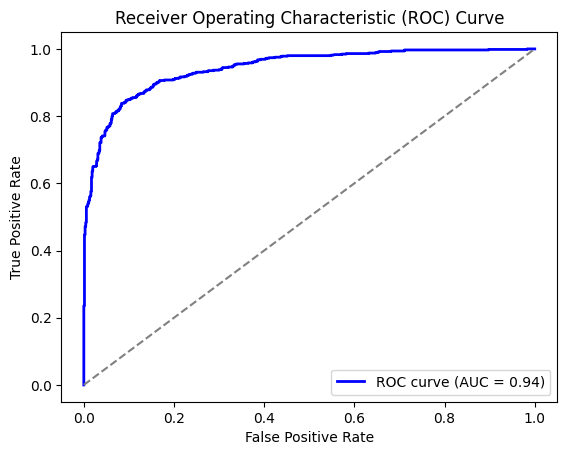

Metrics saved successfully


In [15]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 649ms/step - accuracy: 0.6239 - loss: 0.7563 - val_accuracy: 0.8165 - val_loss: 0.3960
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 679ms/step - accuracy: 0.8005 - loss: 0.4162 - val_accuracy: 0.8434 - val_loss: 0.3622
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.8036 - loss: 0.4126 - val_accuracy: 0.8339 - val_loss: 0.3654
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.8071 - loss: 0.3942 - val_accuracy: 0.8465 - val_loss: 0.3584
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.8333 - loss: 0.3603 - val_accuracy: 0.8228 - val_loss: 0.3769
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 679ms/step - accuracy: 0.8488 - loss: 0.3437 - val_accuracy: 0.8544 - val_loss: 0.3300
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.8482 - loss: 0.3379 - val_accuracy: 0.8687 - val_loss: 0.3207
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.8437 - loss: 0.3367 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 492ms/step
Inference Time: 21.519978523254395 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 538ms/step - accuracy: 0.8299 - loss: 0.3428
Validation Loss: 0.3163314461708069
Validation Accuracy: 0.8560126423835754
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 540ms/step - accuracy: 0.8485 - loss: 0.3244
Test Loss: 0.3376530408859253
Test Accuracy: 0.8523985147476196
ROC AUC Score: 0.9344284298790467
Confusion Matrix:
[[617  89]
 [111 538]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       706
           1       0.86      0.83      0.84       649

    accuracy                           0.85      1355
   macro avg       0.85      0.85      0.85      1355
weighted avg       0.85      0.85      0.85      1355



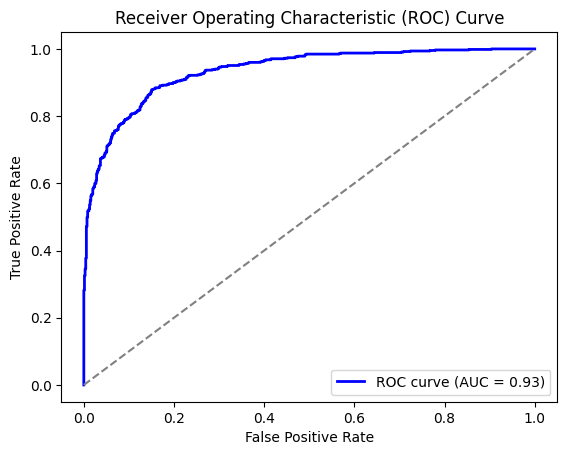

Metrics saved successfully


In [11]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score,cohen_kappa_score,balanced_accuracy_score,matthews_corrcoef
# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [12]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.8931 - loss: 0.2717 - val_accuracy: 0.8465 - val_loss: 0.3380
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.8793 - loss: 0.2831 - val_accuracy: 0.8639 - val_loss: 0.3297
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.8664 - loss: 0.2725 - val_accuracy: 0.8766 - val_loss: 0.3085
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.8782 - loss: 0.2784 - val_accuracy: 0.8782 - val_loss: 0.2997
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.8814 - loss: 0.2513 - val_accuracy: 0.8576 - val_loss: 0.3273
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.8972 - loss: 0.2529 - val_accuracy: 0.8718 - val_loss: 0.3052
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 676ms/step - accuracy: 0.8853 - loss: 0.2450 - val_accuracy: 0.8513 - val_loss: 0.3442
Epoch 8/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 680ms/step - accuracy: 0.8887 - loss: 0.2593 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 529ms/step
Inference Time: 23.126959800720215 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 530ms/step - accuracy: 0.8636 - loss: 0.3306
Validation Loss: 0.2996818423271179
Validation Accuracy: 0.878164529800415
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 531ms/step - accuracy: 0.8718 - loss: 0.3076
Test Loss: 0.31549620628356934
Test Accuracy: 0.8752767443656921
ROC AUC Score: 0.943033955049608
Confusion Matrix:
[[643  63]
 [106 543]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       706
           1       0.90      0.84      0.87       649

    accuracy                           0.88      1355
   macro avg       0.88      0.87      0.87      1355
weighted avg       0.88      0.88      0.87      1355



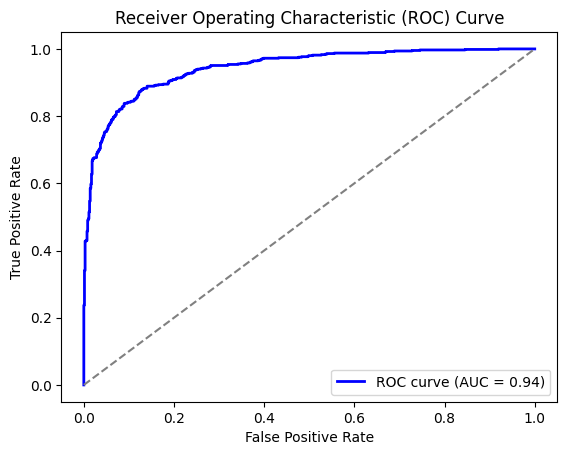

Metrics saved successfully


In [13]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [14]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 681ms/step - accuracy: 0.8852 - loss: 0.2534 - val_accuracy: 0.8671 - val_loss: 0.3176
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 679ms/step - accuracy: 0.8997 - loss: 0.2492 - val_accuracy: 0.8845 - val_loss: 0.2981
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.8920 - loss: 0.2471 - val_accuracy: 0.8734 - val_loss: 0.3151
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.8859 - loss: 0.2534 - val_accuracy: 0.8845 - val_loss: 0.2963
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.8910 - loss: 0.2313 - val_accuracy: 0.8465 - val_loss: 0.3536
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 677ms/step - accuracy: 0.8919 - loss: 0.2492 - val_accuracy: 0.8797 - val_loss: 0.3242
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 682ms/step - accuracy: 0.9128 - loss: 0.2194 - val_accuracy: 0.8592 - val_loss: 0.3252
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.9000 - loss: 0.2301 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 527ms/step
Inference Time: 23.067304611206055 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 530ms/step - accuracy: 0.8620 - loss: 0.3411
Validation Loss: 0.2954867482185364
Validation Accuracy: 0.8876582384109497
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 531ms/step - accuracy: 0.8725 - loss: 0.3093
Test Loss: 0.30675533413887024
Test Accuracy: 0.8782287836074829
ROC AUC Score: 0.9484312321854935
Confusion Matrix:
[[629  77]
 [ 88 561]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       706
           1       0.88      0.86      0.87       649

    accuracy                           0.88      1355
   macro avg       0.88      0.88      0.88      1355
weighted avg       0.88      0.88      0.88      1355



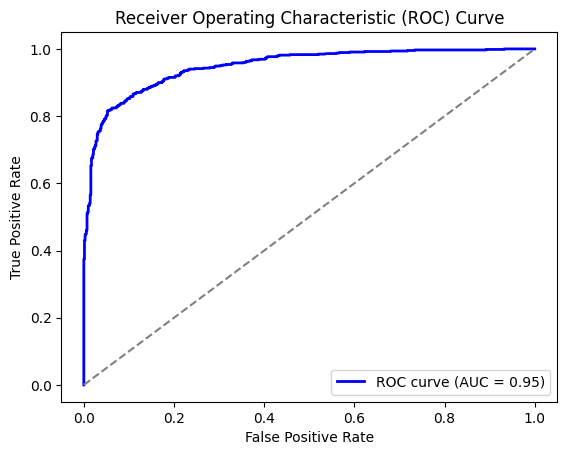

Metrics saved successfully


In [15]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['Resnet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add additional layers
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,784,321 (94.54 MB)

 Trainable params: 1,196,609 (4.56 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 692ms/step - accuracy: 0.5859 - loss: 1.1924 - val_accuracy: 0.7991 - val_loss: 0.5088
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 682ms/step - accuracy: 0.7077 - loss: 0.5397 - val_accuracy: 0.8196 - val_loss: 0.4434
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.7630 - loss: 0.4412 - val_accuracy: 0.8133 - val_loss: 0.3777
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 684ms/step - accuracy: 0.8116 - loss: 0.3991 - val_accuracy: 0.8608 - val_loss: 0.3593
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.8287 - loss: 0.3664 - val_accuracy: 0.8608 - val_loss: 0.3602
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 684ms/step - accuracy: 0.8148 - loss: 0.3533 - val_accuracy: 0.8687 - val_loss: 0.3006
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.8360 - loss: 0.3454 - val_accuracy: 0.8497 - val_loss: 0.3417
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.8450 - loss: 0.3180 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 545ms/step
Inference Time: 24.31853485107422 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 535ms/step - accuracy: 0.8707 - loss: 0.3048
Validation Loss: 0.2628408670425415
Validation Accuracy: 0.8939873576164246
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 533ms/step - accuracy: 0.8753 - loss: 0.2872
Test Loss: 0.29427966475486755
Test Accuracy: 0.8752767443656921
ROC AUC Score: 0.9514037722012947
Confusion Matrix:
[[624  82]
 [ 87 562]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       706
           1       0.87      0.87      0.87       649

    accuracy                           0.88      1355
   macro avg       0.88      0.87      0.88      1355
weighted avg       0.88      0.88      0.88      1355



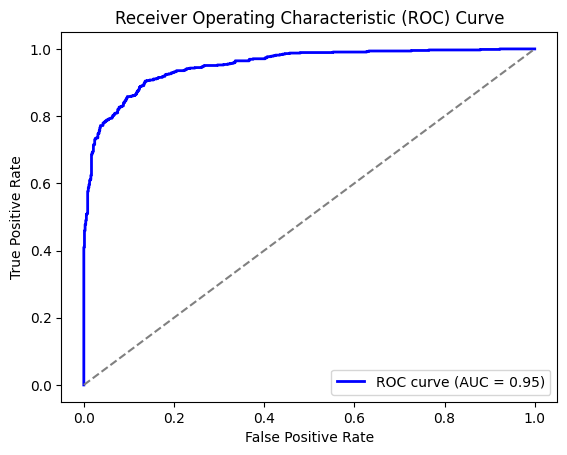

Metrics saved successfully


In [18]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [19]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 687ms/step - accuracy: 0.9089 - loss: 0.1911 - val_accuracy: 0.8877 - val_loss: 0.2825
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.8968 - loss: 0.2316 - val_accuracy: 0.8797 - val_loss: 0.2988
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.9004 - loss: 0.2057 - val_accuracy: 0.8972 - val_loss: 0.2920
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.9271 - loss: 0.1734 - val_accuracy: 0.8956 - val_loss: 0.3108
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.9280 - loss: 0.1641 - val_accuracy: 0.8924 - val_loss: 0.3080
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 684ms/step - accuracy: 0.9413 - loss: 0.1493 - val_accuracy: 0.8845 - val_loss: 0.3160
Training Time: 324.1960799694061 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 530ms/step
Inference Time: 23.17290997505188 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 532ms/step - accuracy: 0.8694 - loss: 0.3315
Validation Loss: 0.28254178166389465
Validation Accuracy: 0.8876582384109497
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 529ms/step - accuracy: 0.8701 - loss: 0.2907
Test Loss: 0.29689717292785645
Test Accuracy: 0.8767527937889099
ROC AUC Score: 0.9557796479220593
Confusion Matrix:
[[640  66]
 [101 548]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       706
           1       0.89      0.84      0.87       649

    accuracy                           0.88      1355
   macro avg       0.88      0.88      0.88      1355
weighted avg       0.88      0.88      0.88      1355



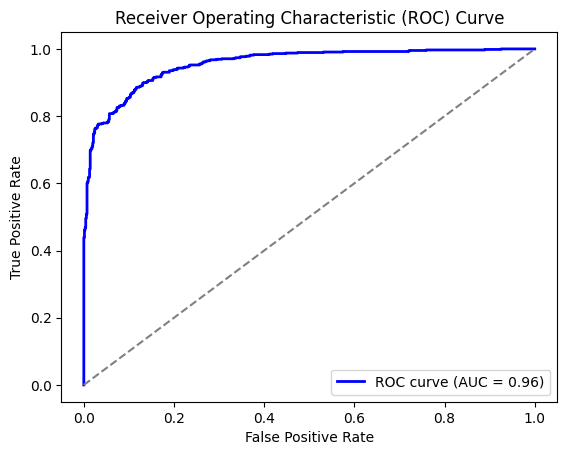

Metrics saved successfully


In [20]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [21]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 685ms/step - accuracy: 0.9155 - loss: 0.1945 - val_accuracy: 0.8861 - val_loss: 0.2941
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 682ms/step - accuracy: 0.8951 - loss: 0.2138 - val_accuracy: 0.8592 - val_loss: 0.2934
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 681ms/step - accuracy: 0.9234 - loss: 0.1931 - val_accuracy: 0.8908 - val_loss: 0.3016
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 682ms/step - accuracy: 0.9172 - loss: 0.1815 - val_accuracy: 0.8877 - val_loss: 0.3254
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 682ms/step - accuracy: 0.9353 - loss: 0.1615 - val_accuracy: 0.8797 - val_loss: 0.2951
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.9269 - loss: 0.1672 - val_accuracy: 0.8734 - val_loss: 0.3098
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 682ms/step - accuracy: 0.9180 - loss: 0.1812 - val_accuracy: 0.8940 - val_loss: 0.3433
Training Time: 377.4067039489746 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 529ms/step
Inference Time: 23.129331350326538 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 530ms/step - accuracy: 0.8494 - loss: 0.3418
Validation Loss: 0.2934362292289734
Validation Accuracy: 0.8591772317886353
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 531ms/step - accuracy: 0.8601 - loss: 0.3370
Test Loss: 0.3452918231487274
Test Accuracy: 0.8671586513519287
ROC AUC Score: 0.9544461516300956
Confusion Matrix:
[[564 142]
 [ 38 611]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       706
           1       0.81      0.94      0.87       649

    accuracy                           0.87      1355
   macro avg       0.87      0.87      0.87      1355
weighted avg       0.88      0.87      0.87      1355



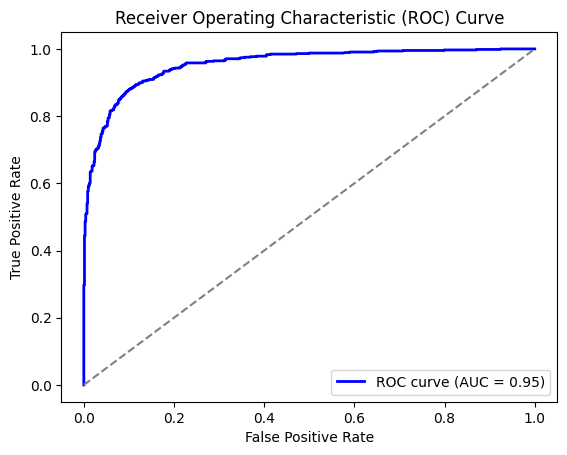

Metrics saved successfully


In [22]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [23]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 684ms/step - accuracy: 0.9172 - loss: 0.1967 - val_accuracy: 0.8908 - val_loss: 0.3386
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 688ms/step - accuracy: 0.9270 - loss: 0.1591 - val_accuracy: 0.8797 - val_loss: 0.3664
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 684ms/step - accuracy: 0.8902 - loss: 0.2352 - val_accuracy: 0.8845 - val_loss: 0.3224
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 685ms/step - accuracy: 0.8922 - loss: 0.2077 - val_accuracy: 0.8924 - val_loss: 0.3172
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 684ms/step - accuracy: 0.9092 - loss: 0.1760 - val_accuracy: 0.8892 - val_loss: 0.2949
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 685ms/step - accuracy: 0.9229 - loss: 0.1724 - val_accuracy: 0.8813 - val_loss: 0.2748
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 684ms/step - accuracy: 0.9194 - loss: 0.1604 - val_accuracy: 0.8877 - val_loss: 0.2836
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 685ms/step - accuracy: 0.9148 - loss: 0.1622 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 530ms/step
Inference Time: 23.163548946380615 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 531ms/step - accuracy: 0.8644 - loss: 0.3254
Validation Loss: 0.2747870981693268
Validation Accuracy: 0.8813291192054749
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 530ms/step - accuracy: 0.8726 - loss: 0.3047
Test Loss: 0.3162587285041809
Test Accuracy: 0.8782287836074829
ROC AUC Score: 0.9570542172093044
Confusion Matrix:
[[615  91]
 [ 74 575]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       706
           1       0.86      0.89      0.87       649

    accuracy                           0.88      1355
   macro avg       0.88      0.88      0.88      1355
weighted avg       0.88      0.88      0.88      1355



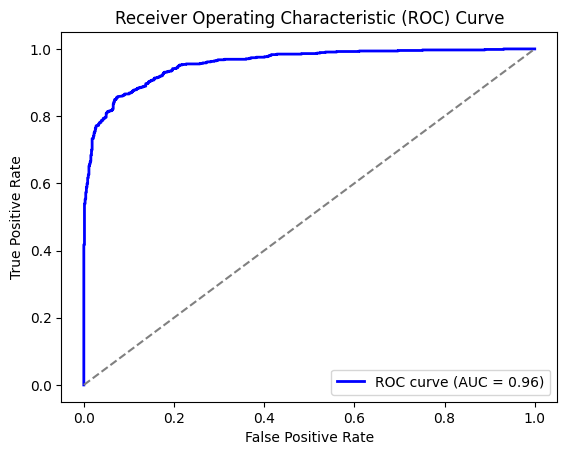

Metrics saved successfully


In [24]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+LSTM+Dense

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Extract features using ResNet
resnet_output = resnet_base.output
flattened_output = Flatten()(resnet_output)

# Reshape features for LSTM
reshaped_output = tf.keras.layers.Reshape((1, flattened_output.shape[1]))(flattened_output)

# LSTM layer
lstm_output = LSTM(128)(reshaped_output)

# Dense layer for classification
dense_output = Dense(64, activation='relu')(lstm_output)
predictions = Dense(1, activation='sigmoid')(dense_output)

# Create the model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 75,042,305 (286.26 MB)

 Trainable params: 51,454,593 (196.28 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [26]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 78s 961ms/step - accuracy: 0.6542 - loss: 0.6123 - val_accuracy: 0.7484 - val_loss: 0.5395
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 950ms/step - accuracy: 0.7829 - loss: 0.4885 - val_accuracy: 0.7627 - val_loss: 0.4754
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 950ms/step - accuracy: 0.7990 - loss: 0.4421 - val_accuracy: 0.7832 - val_loss: 0.4635
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 76s 957ms/step - accuracy: 0.8043 - loss: 0.4176 - val_accuracy: 0.7864 - val_loss: 0.4671
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 951ms/step - accuracy: 0.8017 - loss: 0.4469 - val_accuracy: 0.7278 - val_loss: 0.5164
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 952ms/step - accuracy: 0.8074 - loss: 0.4203 - val_accuracy: 0.7864 - val_loss: 0.4349
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 952ms/step - accuracy: 0.7770 - loss: 0.4384 - val_accuracy: 0.7278 - val_loss: 0.4953
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 76s 962ms/step - accuracy: 0.7946 - loss: 0.4339 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 555ms/step
Inference Time: 24.7961585521698 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 541ms/step - accuracy: 0.7829 - loss: 0.4253
Validation Loss: 0.43494367599487305
Validation Accuracy: 0.7863923907279968
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 541ms/step - accuracy: 0.7829 - loss: 0.4230
Test Loss: 0.42401567101478577
Test Accuracy: 0.7918819189071655
ROC AUC Score: 0.8901033186816065
Confusion Matrix:
[[555 151]
 [131 518]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       706
           1       0.77      0.80      0.79       649

    accuracy                           0.79      1355
   macro avg       0.79      0.79      0.79      1355
weighted avg       0.79      0.79      0.79      1355



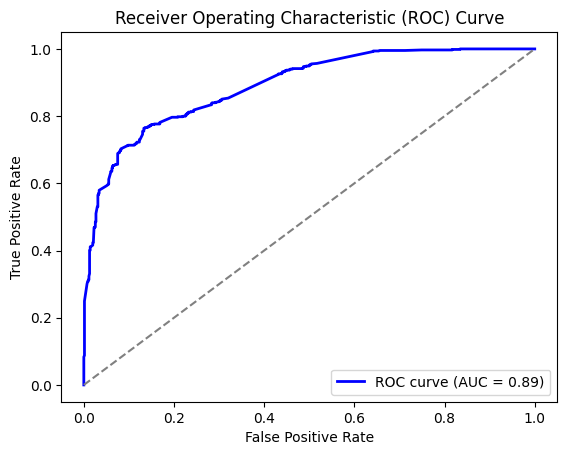

Metrics saved successfully


In [27]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [28]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 953ms/step - accuracy: 0.8264 - loss: 0.3758 - val_accuracy: 0.7975 - val_loss: 0.4016
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 950ms/step - accuracy: 0.8320 - loss: 0.3611 - val_accuracy: 0.7215 - val_loss: 0.5208
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 950ms/step - accuracy: 0.7985 - loss: 0.4334 - val_accuracy: 0.7706 - val_loss: 0.4694
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 950ms/step - accuracy: 0.8173 - loss: 0.4216 - val_accuracy: 0.7516 - val_loss: 0.4871
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 950ms/step - accuracy: 0.7966 - loss: 0.4284 - val_accuracy: 0.8085 - val_loss: 0.4533
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 949ms/step - accuracy: 0.8074 - loss: 0.4143 - val_accuracy: 0.7816 - val_loss: 0.4610
Training Time: 450.61195397377014 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 540ms/step
Inference Time: 23.587730646133423 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 542ms/step - accuracy: 0.8013 - loss: 0.3990
Validation Loss: 0.4015580713748932
Validation Accuracy: 0.797468364238739
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 540ms/step - accuracy: 0.7976 - loss: 0.4078
Test Loss: 0.39949315786361694
Test Accuracy: 0.8140221238136292
ROC AUC Score: 0.8964205118355981
Confusion Matrix:
[[584 122]
 [130 519]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       706
           1       0.81      0.80      0.80       649

    accuracy                           0.81      1355
   macro avg       0.81      0.81      0.81      1355
weighted avg       0.81      0.81      0.81      1355



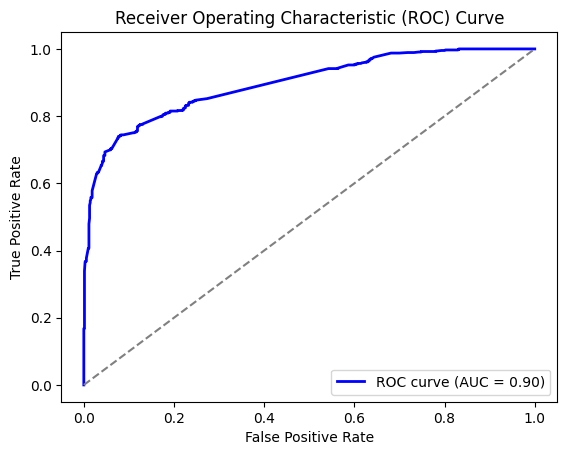

Metrics saved successfully


In [29]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 78s 955ms/step - accuracy: 0.6403 - loss: 0.6311 - val_accuracy: 0.7358 - val_loss: 0.5214
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 953ms/step - accuracy: 0.7639 - loss: 0.4978 - val_accuracy: 0.8070 - val_loss: 0.4479
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 953ms/step - accuracy: 0.8040 - loss: 0.4276 - val_accuracy: 0.7294 - val_loss: 0.5238
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 951ms/step - accuracy: 0.7480 - loss: 0.4819 - val_accuracy: 0.7611 - val_loss: 0.4574
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 952ms/step - accuracy: 0.8080 - loss: 0.4079 - val_accuracy: 0.8022 - val_loss: 0.4443
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 952ms/step - accuracy: 0.7725 - loss: 0.4519 - val_accuracy: 0.7389 - val_loss: 0.4991
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 953ms/step - accuracy: 0.8071 - loss: 0.4128 - val_accuracy: 0.7880 - val_loss: 0.4227
Epoch 8/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 952ms/step - accuracy: 0.8023 - loss: 0.4175 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 555ms/step
Inference Time: 24.83057713508606 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 543ms/step - accuracy: 0.8344 - loss: 0.3931
Validation Loss: 0.38353267312049866
Validation Accuracy: 0.8354430198669434
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 541ms/step - accuracy: 0.8122 - loss: 0.4339
Test Loss: 0.4290505349636078
Test Accuracy: 0.816236138343811
ROC AUC Score: 0.8865873407334011
Confusion Matrix:
[[606 100]
 [149 500]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       706
           1       0.83      0.77      0.80       649

    accuracy                           0.82      1355
   macro avg       0.82      0.81      0.82      1355
weighted avg       0.82      0.82      0.82      1355



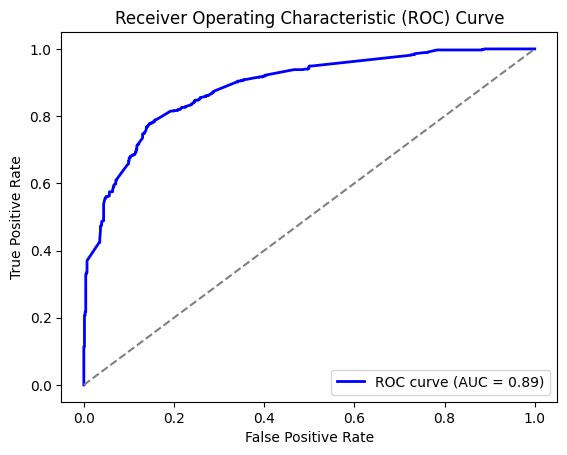

Metrics saved successfully


In [7]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score,cohen_kappa_score,matthews_corrcoef,balanced_accuracy_score
import pandas as pd

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 954ms/step - accuracy: 0.8386 - loss: 0.3567 - val_accuracy: 0.8101 - val_loss: 0.4012
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 953ms/step - accuracy: 0.8471 - loss: 0.3508 - val_accuracy: 0.8307 - val_loss: 0.4237
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 951ms/step - accuracy: 0.8348 - loss: 0.3473 - val_accuracy: 0.7911 - val_loss: 0.4342
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 951ms/step - accuracy: 0.8041 - loss: 0.4021 - val_accuracy: 0.7611 - val_loss: 0.4895
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 951ms/step - accuracy: 0.7998 - loss: 0.4225 - val_accuracy: 0.7991 - val_loss: 0.4096
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 952ms/step - accuracy: 0.8421 - loss: 0.3609 - val_accuracy: 0.8465 - val_loss: 0.3824
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 952ms/step - accuracy: 0.8483 - loss: 0.3569 - val_accuracy: 0.8054 - val_loss: 0.4312
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 952ms/step - accuracy: 0.8528 - loss: 0.3434 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 541ms/step
Inference Time: 23.6193585395813 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 543ms/step - accuracy: 0.8020 - loss: 0.4260
Validation Loss: 0.3725639879703522
Validation Accuracy: 0.8465189933776855
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 541ms/step - accuracy: 0.8416 - loss: 0.4078
Test Loss: 0.4008235037326813
Test Accuracy: 0.8450184464454651
ROC AUC Score: 0.9020305809329672
Confusion Matrix:
[[602 104]
 [106 543]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       706
           1       0.84      0.84      0.84       649

    accuracy                           0.85      1355
   macro avg       0.84      0.84      0.84      1355
weighted avg       0.85      0.85      0.85      1355



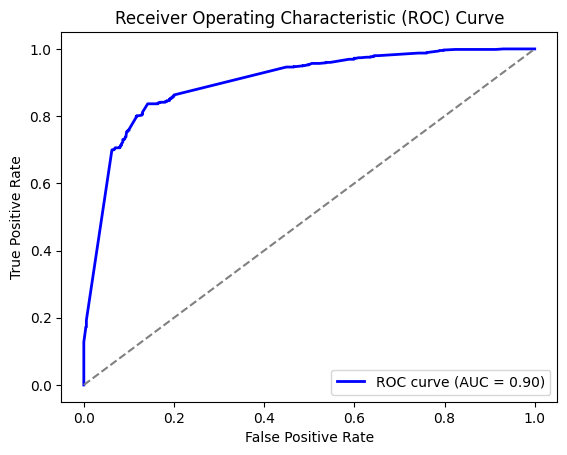

Metrics saved successfully


In [9]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# ResNet+GRU+Dense

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Extract features using ResNet
resnet_output = resnet_base.output
flattened_output = Flatten()(resnet_output)

# Reshape features for GRU
reshaped_output = tf.keras.layers.Reshape((1, flattened_output.shape[1]))(flattened_output)

# GRU layer
gru_output = GRU(128)(reshaped_output)

# Dense layers for classification
dense_output = Dense(64, activation='relu')(gru_output)
predictions = Dense(1, activation='sigmoid')(dense_output)

# Create the model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 62,181,121 (237.20 MB)

 Trainable params: 38,593,409 (147.22 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 73s 891ms/step - accuracy: 0.6520 - loss: 0.6428 - val_accuracy: 0.7231 - val_loss: 0.5284
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 880ms/step - accuracy: 0.7757 - loss: 0.4936 - val_accuracy: 0.7785 - val_loss: 0.4583
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 880ms/step - accuracy: 0.7898 - loss: 0.4620 - val_accuracy: 0.8070 - val_loss: 0.4699
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 880ms/step - accuracy: 0.8072 - loss: 0.4353 - val_accuracy: 0.7516 - val_loss: 0.4876
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 879ms/step - accuracy: 0.7760 - loss: 0.4690 - val_accuracy: 0.8101 - val_loss: 0.4142
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 879ms/step - accuracy: 0.8244 - loss: 0.3782 - val_accuracy: 0.7880 - val_loss: 0.4357
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 879ms/step - accuracy: 0.8314 - loss: 0.3714 - val_accuracy: 0.7627 - val_loss: 0.4607
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 881ms/step - accuracy: 0.7994 - loss: 0.4115 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 551ms/step
Inference Time: 24.647778034210205 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 536ms/step - accuracy: 0.8019 - loss: 0.3796
Validation Loss: 0.3702230453491211
Validation Accuracy: 0.8022152185440063
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 537ms/step - accuracy: 0.8120 - loss: 0.4055
Test Loss: 0.41965240240097046
Test Accuracy: 0.8073800802230835
ROC AUC Score: 0.8951863184589934
Confusion Matrix:
[[599 107]
 [154 495]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       706
           1       0.82      0.76      0.79       649

    accuracy                           0.81      1355
   macro avg       0.81      0.81      0.81      1355
weighted avg       0.81      0.81      0.81      1355



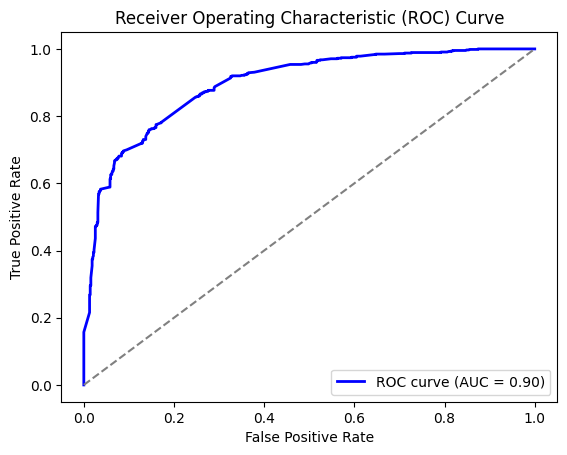

Metrics saved successfully


In [12]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 71s 873ms/step - accuracy: 0.6702 - loss: 0.6367 - val_accuracy: 0.6788 - val_loss: 0.5854
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 880ms/step - accuracy: 0.7280 - loss: 0.5553 - val_accuracy: 0.7310 - val_loss: 0.4999
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 880ms/step - accuracy: 0.7604 - loss: 0.4862 - val_accuracy: 0.6614 - val_loss: 0.5846
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 879ms/step - accuracy: 0.7500 - loss: 0.4860 - val_accuracy: 0.7009 - val_loss: 0.5673
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 881ms/step - accuracy: 0.7125 - loss: 0.5273 - val_accuracy: 0.7658 - val_loss: 0.5042
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 881ms/step - accuracy: 0.7422 - loss: 0.4921 - val_accuracy: 0.7342 - val_loss: 0.5112
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 880ms/step - accuracy: 0.7395 - loss: 0.5069 - val_accuracy: 0.6820 - val_loss: 0.5599
Training Time: 488.91681599617004 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 551ms/step
Inference Time: 24.675754070281982 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 537ms/step - accuracy: 0.7428 - loss: 0.4911
Validation Loss: 0.49993300437927246
Validation Accuracy: 0.7310126423835754
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 536ms/step - accuracy: 0.7217 - loss: 0.5038
Test Loss: 0.5025007128715515
Test Accuracy: 0.724723219871521
ROC AUC Score: 0.8660294547724326
Confusion Matrix:
[[656  50]
 [323 326]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.93      0.78       706
           1       0.87      0.50      0.64       649

    accuracy                           0.72      1355
   macro avg       0.77      0.72      0.71      1355
weighted avg       0.76      0.72      0.71      1355



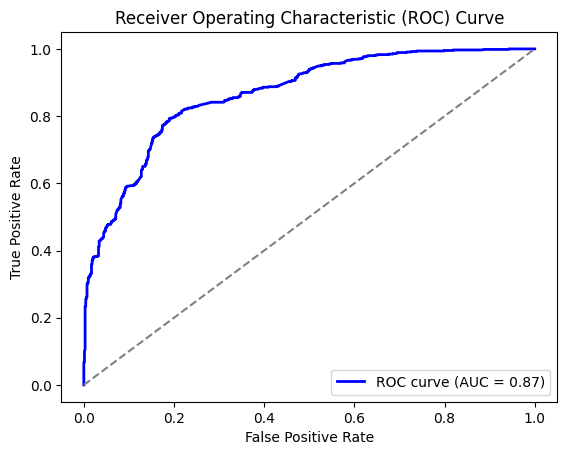

Metrics saved successfully


In [7]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score,matthews_corrcoef,balanced_accuracy_score
# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 883ms/step - accuracy: 0.7721 - loss: 0.4684 - val_accuracy: 0.7690 - val_loss: 0.4811
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 880ms/step - accuracy: 0.7840 - loss: 0.4762 - val_accuracy: 0.7753 - val_loss: 0.4724
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 882ms/step - accuracy: 0.7904 - loss: 0.4344 - val_accuracy: 0.8228 - val_loss: 0.4068
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 881ms/step - accuracy: 0.8267 - loss: 0.3889 - val_accuracy: 0.7231 - val_loss: 0.5104
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 881ms/step - accuracy: 0.7391 - loss: 0.4944 - val_accuracy: 0.7864 - val_loss: 0.4659
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 880ms/step - accuracy: 0.8071 - loss: 0.4194 - val_accuracy: 0.8054 - val_loss: 0.4430
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 880ms/step - accuracy: 0.8303 - loss: 0.4234 - val_accuracy: 0.7927 - val_loss: 0.4392
Epoch 8/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 879ms/step - accuracy: 0.8196 - loss: 0.4036 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 538ms/step
Inference Time: 23.544851303100586 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 538ms/step - accuracy: 0.7955 - loss: 0.4223
Validation Loss: 0.40681958198547363
Validation Accuracy: 0.8227847814559937
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 537ms/step - accuracy: 0.7909 - loss: 0.4248
Test Loss: 0.42623499035835266
Test Accuracy: 0.8029520511627197
ROC AUC Score: 0.893493803934578
Confusion Matrix:
[[551 155]
 [112 537]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       706
           1       0.78      0.83      0.80       649

    accuracy                           0.80      1355
   macro avg       0.80      0.80      0.80      1355
weighted avg       0.80      0.80      0.80      1355



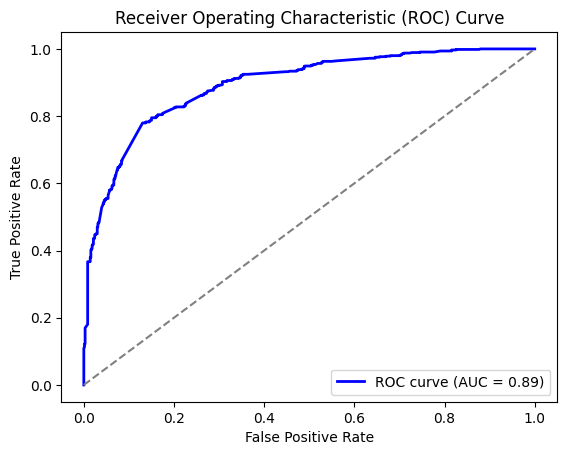

Metrics saved successfully


In [9]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 882ms/step - accuracy: 0.8392 - loss: 0.3801 - val_accuracy: 0.7896 - val_loss: 0.4476
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 880ms/step - accuracy: 0.8118 - loss: 0.4124 - val_accuracy: 0.8022 - val_loss: 0.4412
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 881ms/step - accuracy: 0.8317 - loss: 0.3819 - val_accuracy: 0.7959 - val_loss: 0.4663
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 881ms/step - accuracy: 0.8341 - loss: 0.3857 - val_accuracy: 0.8101 - val_loss: 0.4121
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 881ms/step - accuracy: 0.8609 - loss: 0.3552 - val_accuracy: 0.8228 - val_loss: 0.3770
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 881ms/step - accuracy: 0.8460 - loss: 0.3516 - val_accuracy: 0.8180 - val_loss: 0.4164
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 882ms/step - accuracy: 0.8391 - loss: 0.3719 - val_accuracy: 0.8117 - val_loss: 0.3948
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 69s 880ms/step - accuracy: 0.8369 - loss: 0.3720 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 536ms/step
Inference Time: 23.418805360794067 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 539ms/step - accuracy: 0.8253 - loss: 0.3785
Validation Loss: 0.376964807510376
Validation Accuracy: 0.8227847814559937
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 536ms/step - accuracy: 0.8544 - loss: 0.3525
Test Loss: 0.3602418303489685
Test Accuracy: 0.8509225249290466
ROC AUC Score: 0.9115101900068531
Confusion Matrix:
[[653  53]
 [149 500]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.87       706
           1       0.90      0.77      0.83       649

    accuracy                           0.85      1355
   macro avg       0.86      0.85      0.85      1355
weighted avg       0.86      0.85      0.85      1355



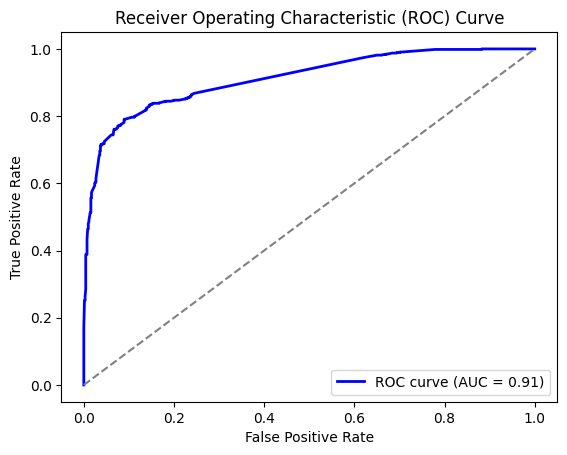

Metrics saved successfully


In [11]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Attention Mechanism+Dense

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Attention
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Preprocess the loaded images
X_train_preprocessed = np.array([img_to_array(image) for image in X_train])
X_val_preprocessed = np.array([img_to_array(image) for image in X_val])
X_test_preprocessed = np.array([img_to_array(image) for image in X_test])

# Preprocess the image data
X_train_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_train_preprocessed)
X_val_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_val_preprocessed)
X_test_preprocessed = tf.keras.applications.resnet50.preprocess_input(X_test_preprocessed)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load ResNet-50 model with pre-trained ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Extract features using ResNet
resnet_output = resnet_base.output
flattened_output = Flatten()(resnet_output)

# Attention mechanism
attention_output = Attention()([flattened_output, flattened_output])

# Dense layers for classification
dense_output = Dense(64, activation='relu')(flattened_output)
predictions = Dense(1, activation='sigmoid')(dense_output)


# Create the model
model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 30,010,369 (114.48 MB)

 Trainable params: 6,422,657 (24.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 674ms/step - accuracy: 0.5263 - loss: 4.7516 - val_accuracy: 0.5316 - val_loss: 0.6730
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 689ms/step - accuracy: 0.5129 - loss: 0.6673 - val_accuracy: 0.5332 - val_loss: 0.6732
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 705ms/step - accuracy: 0.5646 - loss: 0.6519 - val_accuracy: 0.6487 - val_loss: 0.6077
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 704ms/step - accuracy: 0.6965 - loss: 0.5643 - val_accuracy: 0.7595 - val_loss: 0.5431
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 704ms/step - accuracy: 0.8577 - loss: 0.4437 - val_accuracy: 0.8275 - val_loss: 0.4827
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 709ms/step - accuracy: 0.8845 - loss: 0.4115 - val_accuracy: 0.8671 - val_loss: 0.4992
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 703ms/step - accuracy: 0.9244 - loss: 0.3458 - val_accuracy: 0.8623 - val_loss: 0.4807
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 703ms/step - accuracy: 0.9431 - loss: 0.3101 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 548ms/step
Inference Time: 24.506153106689453 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 535ms/step - accuracy: 0.8595 - loss: 0.4976
Validation Loss: 0.44403108954429626
Validation Accuracy: 0.878164529800415
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 534ms/step - accuracy: 0.8808 - loss: 0.4262
Test Loss: 0.4417276084423065
Test Accuracy: 0.8826568126678467
ROC AUC Score: 0.9128906096544258
Confusion Matrix:
[[645  61]
 [ 98 551]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       706
           1       0.90      0.85      0.87       649

    accuracy                           0.88      1355
   macro avg       0.88      0.88      0.88      1355
weighted avg       0.88      0.88      0.88      1355



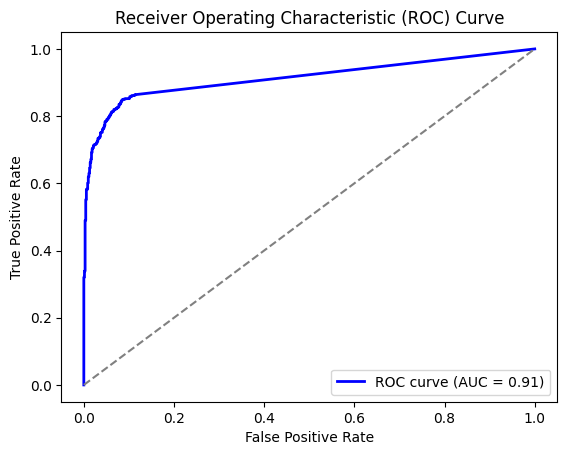

Metrics saved successfully


In [16]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 676ms/step - accuracy: 0.6731 - loss: 5.2556 - val_accuracy: 0.8560 - val_loss: 0.5465
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 690ms/step - accuracy: 0.9218 - loss: 0.2296 - val_accuracy: 0.8639 - val_loss: 0.5017
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 702ms/step - accuracy: 0.9718 - loss: 0.0699 - val_accuracy: 0.8750 - val_loss: 0.4225
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.9878 - loss: 0.0522 - val_accuracy: 0.8797 - val_loss: 0.4574
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.9946 - loss: 0.0286 - val_accuracy: 0.8797 - val_loss: 0.4057
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 701ms/step - accuracy: 0.9980 - loss: 0.0172 - val_accuracy: 0.8924 - val_loss: 0.3941
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 699ms/step - accuracy: 0.9956 - loss: 0.0264 - val_accuracy: 0.8671 - val_loss: 0.5181
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.9954 - loss: 0.0358 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 543ms/step
Inference Time: 24.21660876274109 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 542ms/step - accuracy: 0.8779 - loss: 0.4174
Validation Loss: 0.3940969407558441
Validation Accuracy: 0.892405092716217
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 534ms/step - accuracy: 0.8691 - loss: 0.4482
Test Loss: 0.4453039765357971
Test Accuracy: 0.8789668083190918
ROC AUC Score: 0.954495257467361
Confusion Matrix:
[[606 100]
 [ 64 585]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       706
           1       0.85      0.90      0.88       649

    accuracy                           0.88      1355
   macro avg       0.88      0.88      0.88      1355
weighted avg       0.88      0.88      0.88      1355



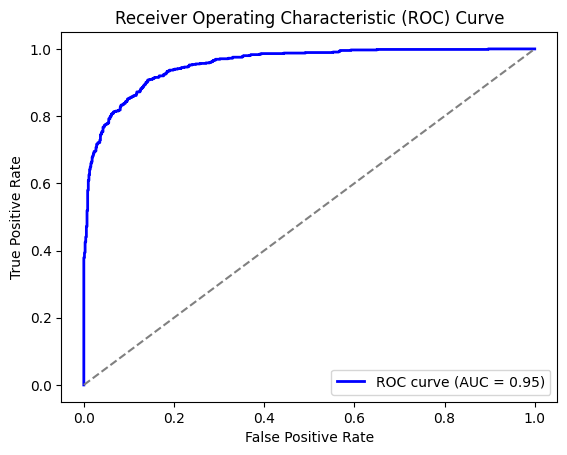

Metrics saved successfully


In [7]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score,balanced_accuracy_score,matthews_corrcoef,cohen_kappa_score
import pandas as pd

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 704ms/step - accuracy: 0.9606 - loss: 0.1502 - val_accuracy: 0.8639 - val_loss: 0.6070
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.9674 - loss: 0.0911 - val_accuracy: 0.8671 - val_loss: 0.4536
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.9819 - loss: 0.0617 - val_accuracy: 0.8608 - val_loss: 0.6151
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 699ms/step - accuracy: 0.9833 - loss: 0.0368 - val_accuracy: 0.8750 - val_loss: 0.5146
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 701ms/step - accuracy: 0.9984 - loss: 0.0080 - val_accuracy: 0.8797 - val_loss: 0.4462
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 701ms/step - accuracy: 0.9975 - loss: 0.0038 - val_accuracy: 0.8861 - val_loss: 0.4593
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.9992 - loss: 0.0015 - val_accuracy: 0.8861 - val_loss: 0.4696
Epoch 8/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.9987 - loss: 0.0018 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 530ms/step
Inference Time: 23.155080795288086 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 531ms/step - accuracy: 0.8728 - loss: 0.4811
Validation Loss: 0.44616445899009705
Validation Accuracy: 0.8797468543052673
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 530ms/step - accuracy: 0.8839 - loss: 0.5373
Test Loss: 0.5138528347015381
Test Accuracy: 0.8848708271980286
ROC AUC Score: 0.954703684465532
Confusion Matrix:
[[635  71]
 [ 85 564]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       706
           1       0.89      0.87      0.88       649

    accuracy                           0.88      1355
   macro avg       0.89      0.88      0.88      1355
weighted avg       0.88      0.88      0.88      1355



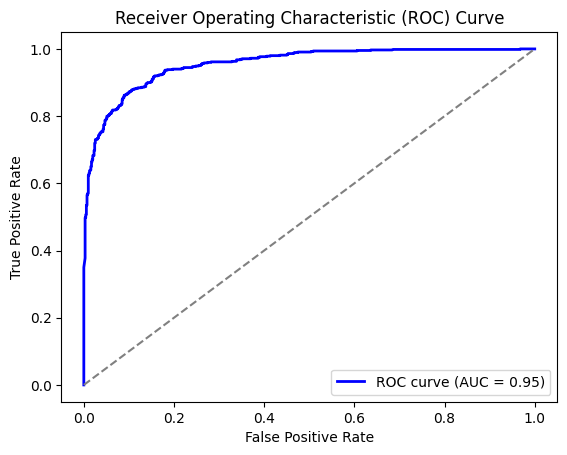

Metrics saved successfully


In [9]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 702ms/step - accuracy: 0.9977 - loss: 0.0038 - val_accuracy: 0.8813 - val_loss: 0.4610
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 699ms/step - accuracy: 0.9994 - loss: 0.0033 - val_accuracy: 0.8877 - val_loss: 0.4656
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 701ms/step - accuracy: 0.9986 - loss: 0.0015 - val_accuracy: 0.8861 - val_loss: 0.4685
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.9989 - loss: 0.0017 - val_accuracy: 0.8877 - val_loss: 0.4782
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 701ms/step - accuracy: 0.9987 - loss: 0.0014 - val_accuracy: 0.8924 - val_loss: 0.4856
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 701ms/step - accuracy: 0.9973 - loss: 0.0025 - val_accuracy: 0.8908 - val_loss: 0.4913
Training Time: 332.16277861595154 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 529ms/step
Inference Time: 23.146461725234985 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 532ms/step - accuracy: 0.8749 - loss: 0.5060
Validation Loss: 0.46095705032348633
Validation Accuracy: 0.8813291192054749
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 530ms/step - accuracy: 0.8818 - loss: 0.5648
Test Loss: 0.5422759652137756
Test Accuracy: 0.8856088519096375
ROC AUC Score: 0.9550703413837807
Confusion Matrix:
[[635  71]
 [ 84 565]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       706
           1       0.89      0.87      0.88       649

    accuracy                           0.89      1355
   macro avg       0.89      0.89      0.89      1355
weighted avg       0.89      0.89      0.89      1355



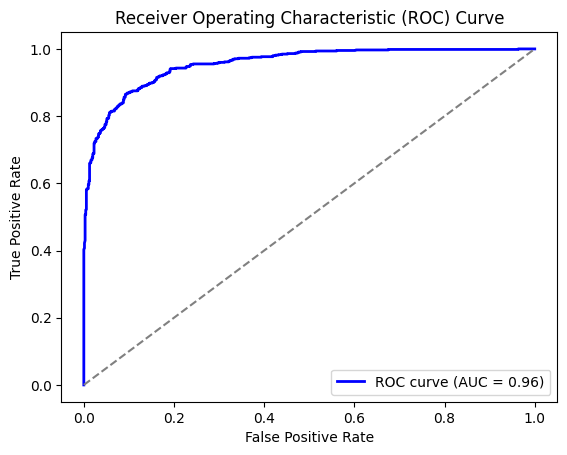

Metrics saved successfully


In [11]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# ResNet+Capsule Network+Dense

In [6]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Flatten, Dense, Input
from tensorflow.keras.models import Model
import time
# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j

# Start time
start_time = time.time()

# Assuming X_train and X_test are your training and testing data respectively

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.repeat(X_train_resized[..., np.newaxis], 3, axis=-1)  # Repeat the channel dimension to match the expected input shape of ResNet50

# Example: Assuming X_test is another dataset
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.repeat(X_test_resized[..., np.newaxis], 3, axis=-1)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Capsule Network
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((-1, 2048))(x)  # Reshape to 3D tensor for Capsule Network (2048 is the output dimension of ResNet50)
x = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
x = Flatten()(x)  # Flatten the output
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Use a single output unit for binary classification

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,936,129 (91.31 MB)

 Trainable params: 348,417 (1.33 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 673ms/step - accuracy: 0.6920 - loss: 0.5799 - val_accuracy: 0.7595 - val_loss: 0.4630
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 683ms/step - accuracy: 0.8270 - loss: 0.3896 - val_accuracy: 0.8592 - val_loss: 0.3085
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 701ms/step - accuracy: 0.8635 - loss: 0.3139 - val_accuracy: 0.7832 - val_loss: 0.4626
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 699ms/step - accuracy: 0.8554 - loss: 0.3196 - val_accuracy: 0.8687 - val_loss: 0.3062
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 698ms/step - accuracy: 0.8774 - loss: 0.2809 - val_accuracy: 0.8734 - val_loss: 0.2962
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 699ms/step - accuracy: 0.8943 - loss: 0.2531 - val_accuracy: 0.8734 - val_loss: 0.2756
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 698ms/step - accuracy: 0.8871 - loss: 0.2567 - val_accuracy: 0.8813 - val_loss: 0.2690
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 697ms/step - accuracy: 0.8674 - loss: 0.2919 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 564ms/step
Inference Time: 26.17063856124878 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 547ms/step - accuracy: 0.8683 - loss: 0.2976
Validation Loss: 0.2605744004249573
Validation Accuracy: 0.8908227682113647
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 548ms/step - accuracy: 0.8646 - loss: 0.3064
Test Loss: 0.29214614629745483
Test Accuracy: 0.8745387196540833
ROC AUC Score: 0.9513459364374044
Confusion Matrix:
[[650  56]
 [114 535]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       706
           1       0.91      0.82      0.86       649

    accuracy                           0.87      1355
   macro avg       0.88      0.87      0.87      1355
weighted avg       0.88      0.87      0.87      1355



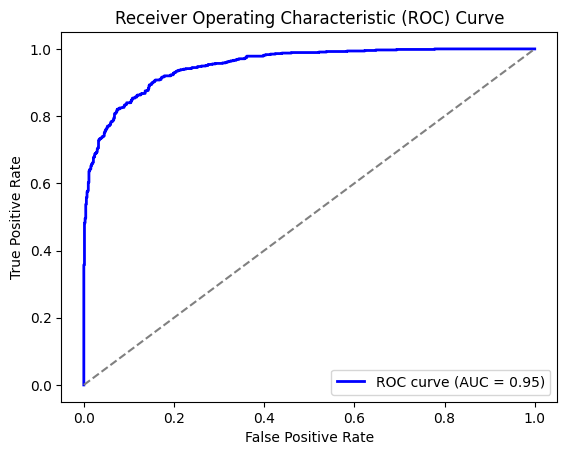

Metrics saved successfully


In [8]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_50_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 666ms/step - accuracy: 0.6845 - loss: 0.5753 - val_accuracy: 0.8339 - val_loss: 0.3812
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 692ms/step - accuracy: 0.8351 - loss: 0.3786 - val_accuracy: 0.8734 - val_loss: 0.3178
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 698ms/step - accuracy: 0.8554 - loss: 0.3194 - val_accuracy: 0.8560 - val_loss: 0.3030
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 697ms/step - accuracy: 0.8579 - loss: 0.3025 - val_accuracy: 0.8782 - val_loss: 0.2893
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 698ms/step - accuracy: 0.8747 - loss: 0.2727 - val_accuracy: 0.8703 - val_loss: 0.3010
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 701ms/step - accuracy: 0.8963 - loss: 0.2439 - val_accuracy: 0.8766 - val_loss: 0.2812
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 697ms/step - accuracy: 0.8951 - loss: 0.2345 - val_accuracy: 0.8639 - val_loss: 0.3030
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 699ms/step - accuracy: 0.9159 - loss: 0.1889 - 

43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 563ms/step
Inference Time: 25.746329307556152 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 540ms/step - accuracy: 0.8363 - loss: 0.3135
Validation Loss: 0.280428022146225
Validation Accuracy: 0.8623417615890503
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 545ms/step - accuracy: 0.8564 - loss: 0.3384
Test Loss: 0.3220541179180145
Test Accuracy: 0.8664206862449646
ROC AUC Score: 0.9487051336333518
Confusion Matrix:
[[612  94]
 [ 87 562]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       706
           1       0.86      0.87      0.86       649

    accuracy                           0.87      1355
   macro avg       0.87      0.87      0.87      1355
weighted avg       0.87      0.87      0.87      1355



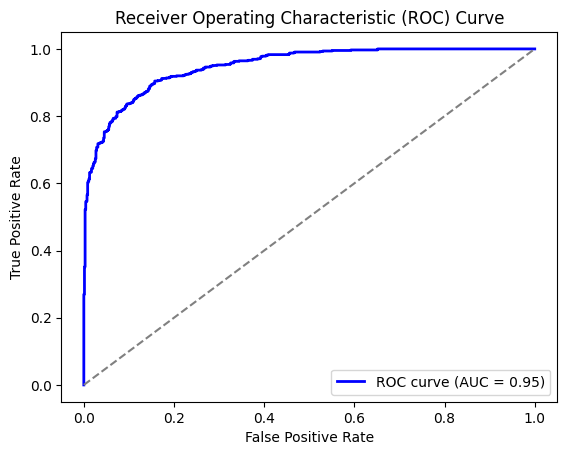

Metrics saved successfully


In [8]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_100_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [9]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 696ms/step - accuracy: 0.9295 - loss: 0.1735 - val_accuracy: 0.8655 - val_loss: 0.3602
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 699ms/step - accuracy: 0.9327 - loss: 0.1637 - val_accuracy: 0.8750 - val_loss: 0.2862
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.9333 - loss: 0.1543 - val_accuracy: 0.8734 - val_loss: 0.3347
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 699ms/step - accuracy: 0.9416 - loss: 0.1384 - val_accuracy: 0.8782 - val_loss: 0.3407
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 698ms/step - accuracy: 0.9590 - loss: 0.1084 - val_accuracy: 0.8623 - val_loss: 0.4264
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 697ms/step - accuracy: 0.9547 - loss: 0.1106 - val_accuracy: 0.8829 - val_loss: 0.3123
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 700ms/step - accuracy: 0.9644 - loss: 0.0863 - val_accuracy: 0.8892 - val_loss: 0.3408
Training Time: 394.0754294395447 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 544ms/step
Inference Time: 23.875269412994385 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 551ms/step - accuracy: 0.8610 - loss: 0.3202
Validation Loss: 0.2862396538257599
Validation Accuracy: 0.875
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 545ms/step - accuracy: 0.8712 - loss: 0.3288
Test Loss: 0.32413795590400696
Test Accuracy: 0.8715867400169373
ROC AUC Score: 0.9480940387696042
Confusion Matrix:
[[646  60]
 [114 535]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       706
           1       0.90      0.82      0.86       649

    accuracy                           0.87      1355
   macro avg       0.87      0.87      0.87      1355
weighted avg       0.87      0.87      0.87      1355



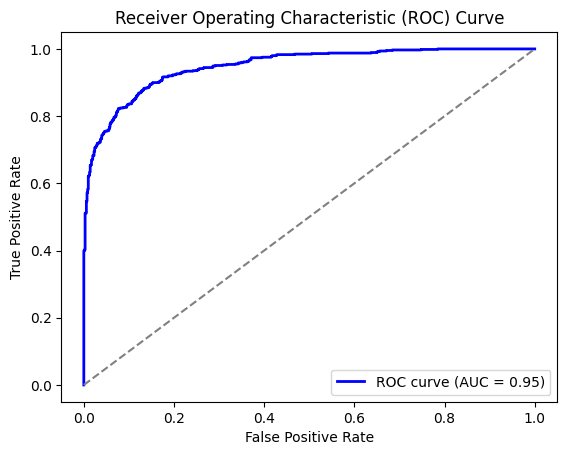

Metrics saved successfully


In [10]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_150_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_preprocessed, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val_preprocessed, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 701ms/step - accuracy: 0.9468 - loss: 0.1272 - val_accuracy: 0.8861 - val_loss: 0.2948
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 698ms/step - accuracy: 0.9543 - loss: 0.1172 - val_accuracy: 0.8877 - val_loss: 0.3135
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 697ms/step - accuracy: 0.9359 - loss: 0.1449 - val_accuracy: 0.8718 - val_loss: 0.3349
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 699ms/step - accuracy: 0.9493 - loss: 0.1298 - val_accuracy: 0.7690 - val_loss: 0.4405
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 698ms/step - accuracy: 0.9375 - loss: 0.1484 - val_accuracy: 0.8797 - val_loss: 0.3695
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 55s 698ms/step - accuracy: 0.9500 - loss: 0.1093 - val_accuracy: 0.8813 - val_loss: 0.3534
Training Time: 331.5289087295532 seconds


43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 546ms/step
Inference Time: 24.090041160583496 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 550ms/step - accuracy: 0.8734 - loss: 0.3206
Validation Loss: 0.2947981059551239
Validation Accuracy: 0.8860759735107422
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 548ms/step - accuracy: 0.8722 - loss: 0.3354
Test Loss: 0.3348983824253082
Test Accuracy: 0.8738007545471191
ROC AUC Score: 0.9484737905777901
Confusion Matrix:
[[613  93]
 [ 78 571]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       706
           1       0.86      0.88      0.87       649

    accuracy                           0.87      1355
   macro avg       0.87      0.87      0.87      1355
weighted avg       0.87      0.87      0.87      1355



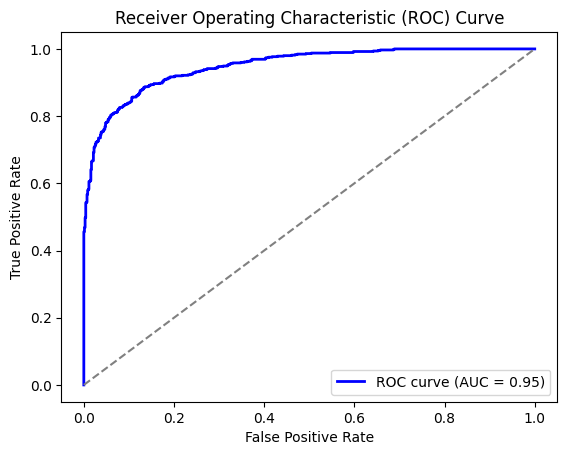

Metrics saved successfully


In [12]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Record start time for inference
start_inference_time = time.time()

# Generate predictions on test data
y_pred_proba = model.predict(X_test_preprocessed)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Record end time for inference
end_inference_time = time.time()

# Calculate inference time
inference_time = end_inference_time - start_inference_time
print("Inference Time:", inference_time, "seconds")

# Print validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
print("ROC AUC Score:", roc_auc)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)
print("Classification Report:")
print(class_report)

kappa=cohen_kappa_score(y_test,y_pred_binary)
mcc=matthews_corrcoef(y_test,y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

existing_metrics_df=pd.read_csv('ResNet_5000_epoch_200_metrics.csv')
metrics={
    'Combination':['ResNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('ResNet_5000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")
